In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download bulentsiyah/semantic-drone-dataset -p /content/sample_data/ --unzip

100% 3.88G/3.89G [00:51<00:00, 108MB/s]
100% 3.89G/3.89G [00:51<00:00, 80.9MB/s]


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
IMAGE_PATH = '../content/sample_data/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../content/sample_data/dataset/semantic_drone_dataset/label_images_semantic/'

In [5]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [6]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


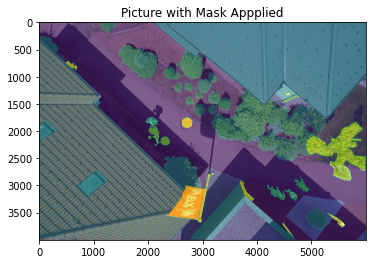

In [7]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [8]:
class DroneDataset(Dataset):

  def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
    self.img_path = img_path
    self.mask_path = mask_path
    self.X = X
    self.transform = transform
    self.patches = patch
    self.mean = mean
    self.std = std
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.down1 = self.down_block(in_channels, 64, 7, 3)
        self.down2 = self.down_block(64, 128, 3, 1)
        self.down3 = self.down_block(128, 256,  3, 1)
        self.down4 = self.down_block(256, 512,  3, 1)
        self.down5 = self.down_block(512, 1024, 3, 1)

        self.last = self.down_block(128, 64, 3, 1)
        self.last1 = torch.nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        

        self.upconv5 = self.expand_block(1024, 512, 3, 1)
        # self.upconv4 = self.expand_block(512 * 2, 256, 3, 1)
        self.upconv4 = self.expand_block(512, 256, 3, 1)

        self.upconv3 = self.expand_block(256 * 2, 128, 3, 1)
        # self.upconv3 = self.expand_block(256, 128, 3, 1)

        self.upconv2 = self.expand_block(128 * 2, 64, 3, 1)

      
    def down_block(self, in_channels, out_channels, kernel_size, padding):
        down = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )
        return down

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

    def forward(self, x):
        # downsampling part
        conv1 = self.down1(x)
        conv2 = self.down2(self.pool(conv1))
        conv3 = self.down3(self.pool(conv2))
        conv4 = self.down4(self.pool(conv3))
        # conv5 = self.down5(self.pool(conv4))

        # upconv5 = self.upconv5(conv5)
        # upconv4 = self.upconv4(torch.cat([upconv5, conv4], 1))
        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.last1(self.last(torch.cat([upconv2, conv1], 1)))
        return upconv1 

In [12]:
model = UNET(3, 23)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
epochs = 15

In [13]:
def fit():
    # running 
    train_losses = []
    test_losses = []
    model.to(device)
    fit_time = time.time()

    for e in range(epochs):
      print(e)
      since = time.time()
      model.train()
      for i, data in enumerate(tqdm(train_loader)):
        image_tiles, mask_tiles = data
        image = image_tiles.to(device); mask = mask_tiles.to(device);
 
        output = model(image)
        loss = criterion(output, mask)
        print(loss)
        optimizer.step()           
        optimizer.zero_grad()


In [14]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 10 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model.pt')
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [15]:
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/1024/1024)

0.0


In [16]:
summary(model, (3, 704, 1056))

In [17]:
# !pip install -q segmentation-models-pytorch
# import segmentation_models_pytorch as smp

# model1 = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
# # inputs = 
# # inputs = inputs.cuda()
# summary(model1, (3, 704, 1056).cuda())
# # optimizer = torch.optim.Adam(model.parameters())

In [18]:
train_loss, valid_loss = train(model, train_loader, val_loader, criterion, optimizer, pixel_accuracy, epochs=50)
# fit()

Epoch 0/49
----------
Current step: 10  Loss: 2.799731969833374  Acc: 0.22546622116046833  AllocMem (Mb): 461.8564453125
Current step: 20  Loss: 2.1981797218322754  Acc: 0.5064646823347108  AllocMem (Mb): 461.8564453125
Current step: 30  Loss: 2.4303171634674072  Acc: 0.34104629390495866  AllocMem (Mb): 461.8564453125
Current step: 40  Loss: 1.5238181352615356  Acc: 0.7115150080348944  AllocMem (Mb): 461.8564453125
Current step: 50  Loss: 2.044842481613159  Acc: 0.4693696553604224  AllocMem (Mb): 461.8564453125
Current step: 60  Loss: 1.7215133905410767  Acc: 0.526878335915978  AllocMem (Mb): 461.8564453125
Current step: 70  Loss: 1.8245784044265747  Acc: 0.3470998156278696  AllocMem (Mb): 461.8564453125
Current step: 80  Loss: 1.523723840713501  Acc: 0.577020202020202  AllocMem (Mb): 461.8564453125
Current step: 90  Loss: 1.5675129890441895  Acc: 0.5232334890094124  AllocMem (Mb): 461.8564453125
Current step: 100  Loss: 2.09533429145813  Acc: 0.2978331790920569  AllocMem (Mb): 461.856

KeyboardInterrupt: ignored

In [19]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [20]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

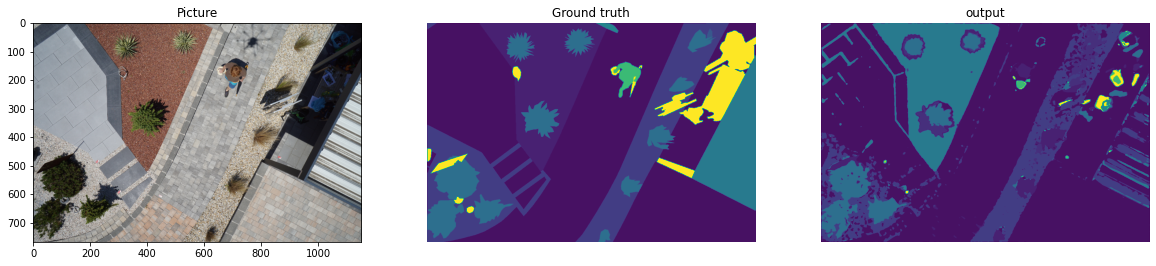

In [21]:
image, mask = test_set[1]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

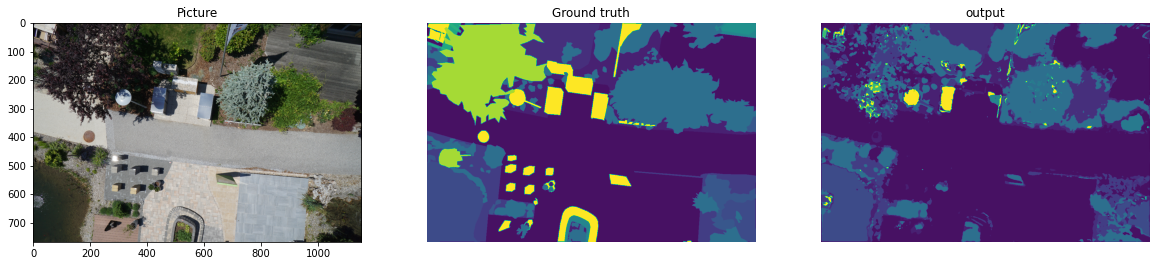

In [22]:
image, mask = test_set[2]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()

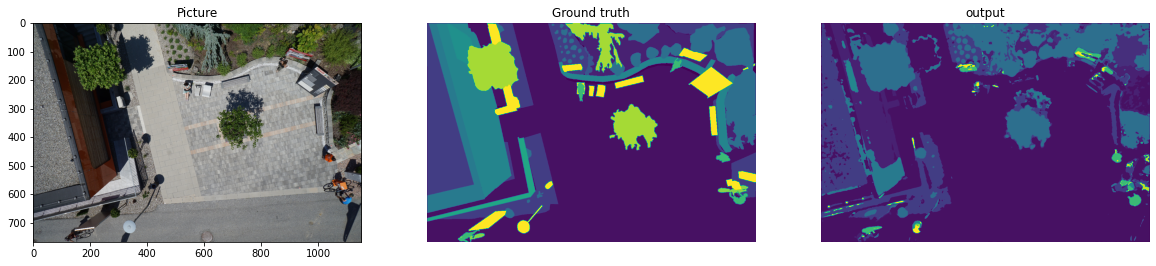

In [23]:
image, mask = test_set[0]
output = predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(output)
ax3.set_title('output')
ax3.set_axis_off()